<img src="figuras/mbit-logo.png" align="right" style="float" width="200">
<font color="#CA3532"><h1 align="left">Clustering</h1></font>
<h2 align="left">Base de datos sintética. f-cmeans</h2>

Primero importamos las librerías que necesitaremos. También activaremos el modo *inline* para los gráficos generados por *matplotlib*. También inicializaremos la semilla del generador de números aleatorios.

In [1]:
COLAB = True

In [2]:
if COLAB:
  !pip install scikit_fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit_fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894079 sha256=f39d03871ecc7c0f4661ace02ca9e4d4f0691752d61af508bcda815f9408810c
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit_fuzzy


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans, cmeans_predict # pip install scikit_fuzzy
from sklearn import metrics

Ahora crearemos un problema no supervisado sintético. El objetivo es entender los conceptos principales con este prolema, luego analizaremos bases de datos reales. Usaremos la función "make_blobs" que genera datos con un número especificado de "blobs". Esta función escoge aleatoriamente los centros de los blobs.

Los parámetros que cambiaremos se comentan aquí:

## Funciones para crear y dibujar los datos en el problema de los clusters elipsoidales

In [4]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados

    return X_rotados

def genera_puntos_gaussiana2D(Npuntos, media, std1, std2, angulo):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * std1 # se multiplica cada atributo por la
    X[1,:] = X[1,:] * std2 # desviación estándar deseada
    X = rota_datos_alrededor_origen(X, angulo)
    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]

    return X.T

def genera_puntos_disco2D(Npuntos, media, radio):
    radios  = radio*np.sqrt(np.random.rand(Npuntos))
    angulos = (2*np.pi)*np.random.rand(Npuntos)
    X = np.zeros((Npuntos,2))
    X[:,0] = media[0] + radios*np.cos(angulos)
    X[:,1] = media[1] + radios*np.sin(angulos)
    return X

def plot_ellipsoid(mean, cov, color, splot, alpha=0.5):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(alpha)
    splot.add_artist(ell)

def plot_ellipsoid_from_data(X, color, splot, alpha=0.5):
    plot_ellipsoid(np.mean(X.T, axis=1), np.cov(X.T), color, splot, alpha)

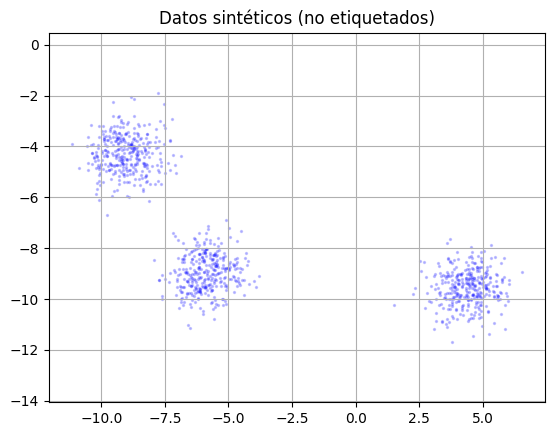

In [5]:
problema = 1

if problema==1:
    Nblobs = 3 # número de "blobs"
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = 0.75) # ancho de cada "blob"

elif problema==2: # blobs de diferente tamanyo
    Nblobs = 3
    stds = [1, 3, 1]
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = stds) # ancho de cada "blob"

elif problema==3: # dos "lunas" acopladas
    X = make_moons(n_samples=1000, noise=.1, random_state=21)[0]

elif problema==4: # circulo dentro de un circulo
    X = make_circles(n_samples=2000, factor=0.5, noise=.05, random_state=21)[0]

elif problema==5: # "Mickey Mouse"
    n_samples = 1000
    X1 = genera_puntos_disco2D(n_samples, [0, 5], 2)
    X2 = genera_puntos_disco2D(n_samples, [10, 5], 2)
    X3 = genera_puntos_disco2D(int(5*5/2/2*n_samples), [5, 0], 5)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)

elif problema==6:
    n_samples = 1000
    #np.random.seed(0)
    X1 = genera_puntos_gaussiana2D(n_samples, [0, 0], 1, 1, 45)
    X2 = genera_puntos_gaussiana2D(n_samples, [10, 0], 3.5, 1, 45)
    X3 = genera_puntos_gaussiana2D(n_samples, [5, 5], 2, 1, 45)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)
    colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
    markers = ['s', 'v', 'o', 'd', 's']


    plt.figure(figsize=(6,6))
    splot = plt.subplot(1, 1, 1)
    for Xi,color in zip(Xs,colors):
        plot_ellipsoid_from_data(Xi, 'b', splot, alpha=0.2)

plt.scatter(X[:,0], X[:,1], color = 'b', s=2, alpha=0.2)
plt.grid()
plt.axis('equal')
plt.title('Datos sintéticos (no etiquetados)')
plt.show()

Ahora usaremos el algoritmo de clustering k-means.
El parámetro principal es el número de clusters. Los otros parámetros se comentan en la celda siguiente y se visualizan los resultados obtenidos por este algoritmo:

In [6]:
def colorea_puntos(u, cs):
    aux = np.zeros((len(u),3))
    nclusters = u.shape[1]
    for i in range(nclusters):
        a = plt_colors.cnames[cs[i]]
        c = [int(a[j:(j+2)],16) for j in range(1,7,2)]
#        print(c)
        for k in range(3):
            aux[:,k] = aux[:,k] + u[:,i]*c[k]
#    return aux.astype(np.int)
    aux = aux/255.
    return aux.clip(max=1.)

#colorea_puntos(np.array([[.5,0,.5],[0,1,0],[0,0,1]]), ['blue', 'red', 'green'])

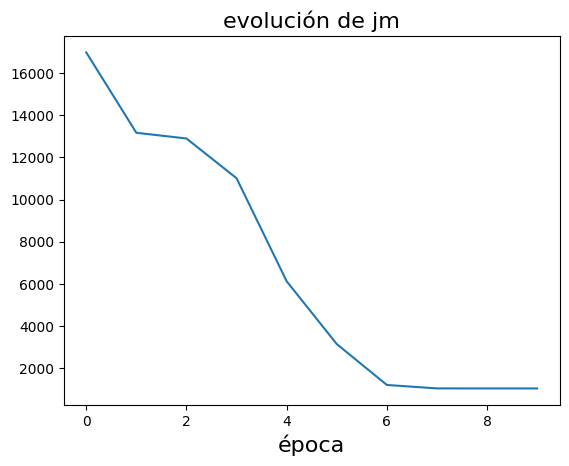

In [19]:
Nclusters = 3    # número de clusters
m = 2
error = 0.005
maxiter = 1000

cntr, u_tr, u0, d, jm, p, fpc = cmeans(X.T, c=Nclusters, m=m, error=error, maxiter=maxiter, init=None)
u_tr = u_tr.T # porque cmeans devuelve un "u" de tamanyo (#clusters, #puntos)

if False:
    kmeans = KMeans(n_clusters=Nclusters,
                    init='random', # random o kmeans++ (más eficiente)
                    n_init=Nrepetitions,
                    max_iter=500,
                    random_state=2)
    kmeans.fit(X)

plt.plot(jm)
plt.title('evolución de jm', fontsize=16)
plt.xlabel('época', fontsize=16)
plt.show()

In [22]:
u_tr

array([[2.05948881e-02, 3.66378156e-02, 9.42767296e-01],
       [5.35155730e-03, 2.52844884e-02, 9.69363954e-01],
       [9.97102630e-01, 9.76210984e-04, 1.92115951e-03],
       ...,
       [4.75128943e-03, 9.70982931e-01, 2.42657795e-02],
       [5.64066948e-03, 9.56223752e-01, 3.81355780e-02],
       [4.86824389e-03, 9.54843931e-01, 4.02878253e-02]])

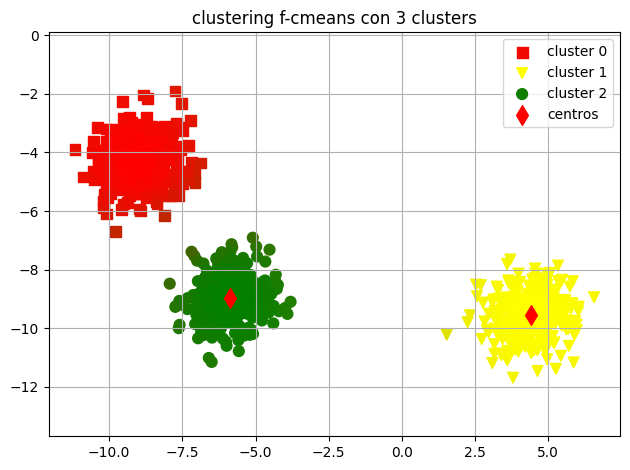

In [9]:
ax = plt.subplot(1,1,1)
colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
colors = ['red', 'yellow', 'green', 'blue']
rgb_puntos = colorea_puntos(u_tr, colors)

markers = ['s', 'v', 'o', 'd', 's']
cluster_labels = u_tr.argmax(axis=1)
for i in range(Nclusters):
    aux = cluster_labels == i
    plt.scatter(X[aux, 0], X[aux, 1],
                s = 60, c = rgb_puntos[aux], marker = markers[i],
                label = 'cluster %d' % (i))

plt.scatter(cntr[:,0], cntr[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
plt.legend()
plt.grid()
plt.title('clustering f-cmeans con %d clusters' % Nclusters)
plt.tight_layout()
plt.axis('equal')
plt.show()
ejes = ax.axes.axis()

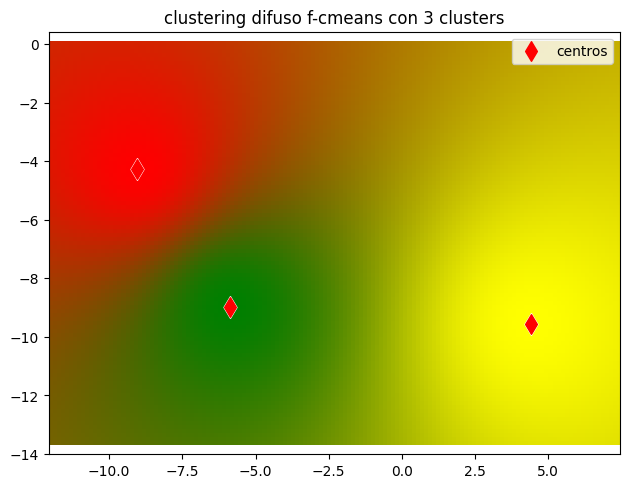

In [10]:
x_min, x_max, y_min, y_max = ejes

h = min([x_max-x_min, y_max-y_min])/100

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
a = np.c_[xx.ravel(), yy.ravel()]
u, u0, d, jm, p, fpc = cmeans_predict(a.T, cntr_trained=cntr, m=m, error=error, maxiter=maxiter)
u = u.T

rgb_puntos = colorea_puntos(u, colors)
aux = rgb_puntos.reshape([xx.shape[0], xx.shape[1], 3])

plt.imshow(aux, origin='lower', extent=ejes, vmax=aux.max(), vmin=aux.min())
plt.scatter(cntr[:,0], cntr[:,1],
            s = 120, marker = 'd',
            c='white')
plt.scatter(cntr[:,0], cntr[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
plt.legend()
plt.title('clustering difuso f-cmeans con %d clusters' % Nclusters)
plt.tight_layout()
plt.axis('equal');

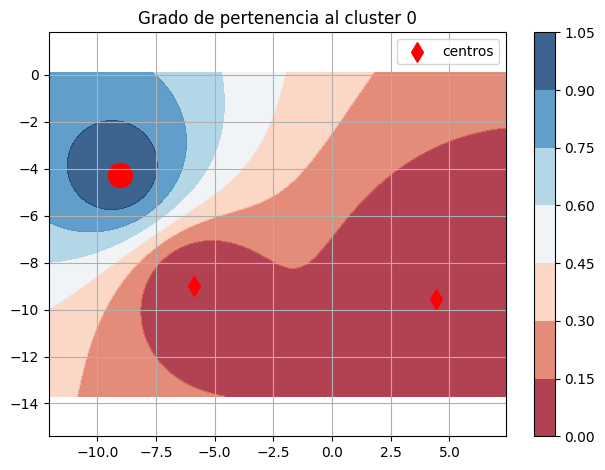

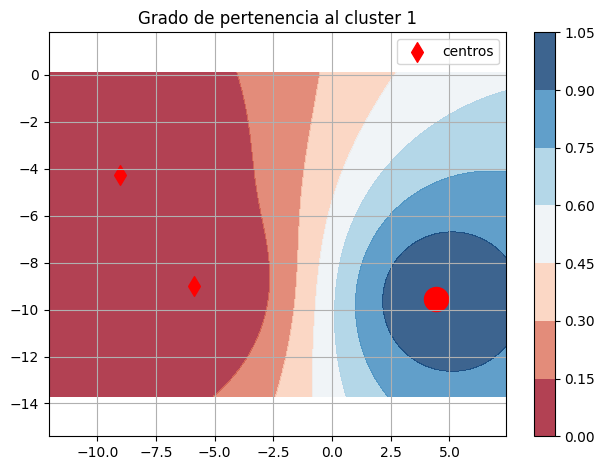

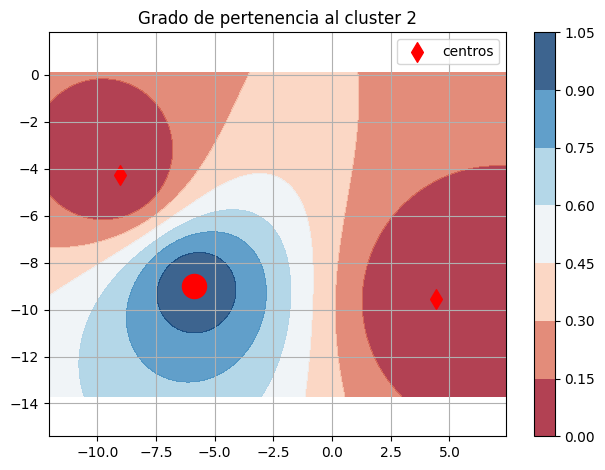

In [11]:
cm = plt.cm.RdBu
for c in range(Nclusters):
    ax = plt.subplot(1,1,1)
    uc = u[:,c]
    uc = uc.reshape(xx.shape)
    plt.contourf(xx, yy, uc, cmap=cm, alpha=.8, vmin=0, vmax=1)
    plt.colorbar()

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.scatter(cntr[:,0], cntr[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
    plt.scatter(cntr[c,0], cntr[c,1], s=300, c='red')
    plt.legend()
    plt.title('Grado de pertenencia al cluster '+str(c))
    plt.grid()
    plt.tight_layout()
    plt.axis('equal')
    plt.show()

Ahora interpretamos el clustering como crisp: consideramos que cada punto pertenece al cluster del cual tiene mayor grado de pertenencia

In [12]:
def soft2crisp(u):
    c = np.zeros(u.shape)
    for i in range(len(u)):
        c[i,u[i].argmax()] = 1
    return  c

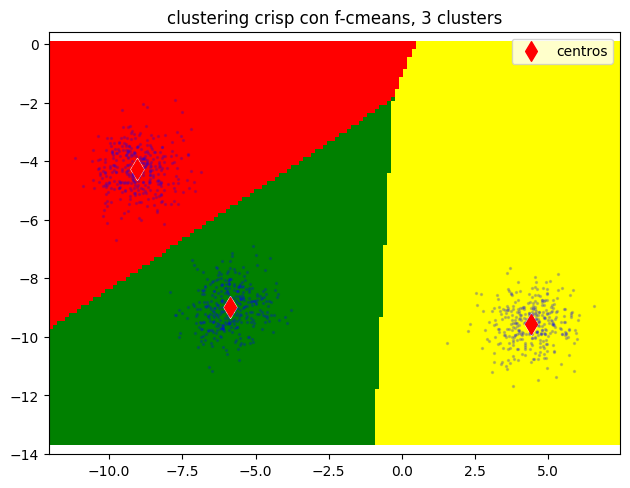

In [13]:
rgb_puntos = colorea_puntos(soft2crisp(u), colors)
aux = rgb_puntos.reshape([xx.shape[0], xx.shape[1], 3])

plt.imshow(aux, origin='lower', extent=ejes, vmax=aux.max(), vmin=aux.min())
plt.scatter(cntr[:,0], cntr[:,1],
            s = 120, marker = 'd',
            c='white')
plt.scatter(X[:,0], X[:,1], color = 'b', s=2, alpha=0.2)
plt.scatter(cntr[:,0], cntr[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
plt.legend()
plt.title(f'clustering crisp con f-cmeans, {Nclusters} clusters')
plt.tight_layout()
plt.axis('equal');

Para elegir el número de clusters usamos el índice fpc:

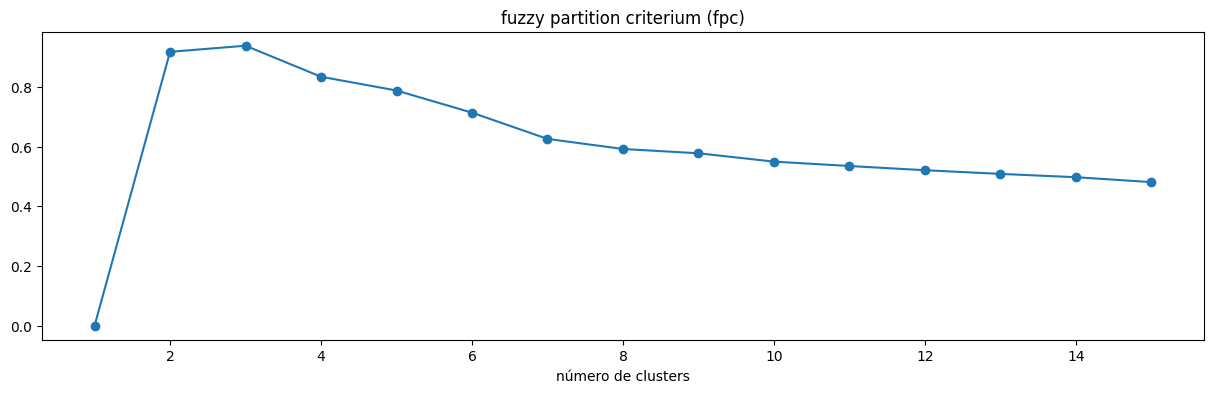

In [14]:
Nclusters_max = 15

fpcs = []
models = []
for k in range(1,Nclusters_max+1):
    cntr, u_tr, u0, d, jm, p, fpc = cmeans(X.T, c=k, m=m, error=error, maxiter=maxiter, init=None)
    if k >1:
        fpcs.append(fpc)
    else:
        fpcs.append(0)

fig = plt.figure(figsize=(15,4))

ax = plt.subplot(1,1,1)
plt.plot(range(1,Nclusters_max+1), fpcs, marker='o')
plt.xlabel('número de clusters')
plt.title('fuzzy partition criterium (fpc)');